In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in Data Set

In [5]:
from google.colab import drive
drive.mount('/content/drive')
raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/household_power_consumption.txt', sep=';', na_values='?', index_col=0,
                       parse_dates=[[0,1]], infer_datetime_format=True, dayfirst=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for i in range(raw_data.shape[1]):
    bad_cnt = raw_data.iloc[:, i].isnull().sum()
    print('Column %d has %d bad values.' % (i, bad_cnt))

In [ ]:
print(raw_data.shape)
# print(raw_data.iloc[4,[2,3,6,7,8]])
print(raw_data)

### Fill missing data with average curve
This method of filling the data will replace each missing value with the average of the last good value and the next good value. If there are multiple missing values, the last good value will be updated as each value is filled in. For example, if the series of data is [0, ?, ?, 4], the filled in set will be [0, 2, 3, 4].  
I think this is a reasonable way to fill in power data since power is continuous and can't change value instantaneously. It might be problematic for the regions where there are many values (multiple days worth) missing, though.

In [6]:
def FillAverageCurve(raw_data, full_row_outage=True, method='curve'):

    filled_data = raw_data.copy()
    if (full_row_outage):
        max_range = 1
    else:
        max_range = filled_data.shape[1]
    
    for col in range(max_range):
        last_row = -2

        null_series = filled_data.iloc[:, col].isnull()
        null_indices = np.where(null_series.values == True)[0].tolist()
        skip_cnt = 0
        for i in range(len(null_indices)):
            row = null_indices[i]

            if (last_row == row - 1):
                new_val = (last_good + next_good) / 2
                filled_data.iloc[row] = new_val
                if (method == 'curve'):
                    last_good = new_val
                continue

            if (i == len(null_indices) - 1):
                # This is the last null value in the column. The next row is good.
                filled_data.iloc[row] = (filled_data.iloc[row - 1] + filled_data.iloc[row + 1]) / 2
            else:
                good_idx = 0
                for k in range(i, len(null_indices)):
                    if (null_indices[k] != null_indices[k + 1] - 1):
                        good_idx = k
                        break
                    elif (k == len(null_indices) - 1):
                        good_idx = k
                next_good = filled_data.iloc[null_indices[good_idx] + 1]
                last_good = filled_data.iloc[row - 1]
                new_val = (last_good + next_good) / 2
                filled_data.iloc[row] = new_val
                if (method == 'curve'):
                    last_good = new_val
                last_row = row

        print('Column %d cleaned' % col)
    return filled_data

In [7]:
filled_data = FillAverageCurve(raw_data)

Column 0 cleaned


In [ ]:
# Check a few missing value locations to verify the fill worked correctly
print(raw_data.iloc[6838])
print(filled_data.iloc[6839])
print(filled_data.iloc[6840])
print(raw_data.iloc[6841])

### Add a new column for apparent power
If I remember my power systems courses correctly, the power utility needs to consider apparent power, which is a combination of both active and reactive power. This next bit of code will calculate the apparent power and add it as a new column. This column will be useful if we want to do analysis related to how much power the utility needs to generate.

In [8]:
# Add apparent power column
filled_data['Sub_metering_remainder'] = (filled_data['Global_active_power'] * 1000 / 60 - 
                                         filled_data['Sub_metering_1'] - filled_data['Sub_metering_2'] - 
                                         filled_data['Sub_metering_3'])

filled_data['Global_apparent_power'] = np.sqrt(filled_data['Global_active_power']**2 +
                                              filled_data['Global_reactive_power']**2)

In [ ]:
print(filled_data.iloc[1000])

In [ ]:
plt.figure(figsize=(30,30))
raw_data.iloc[0:100][['Global_active_power', 'Global_reactive_power']].plot()
# raw_data.iloc[0:100]['Global_active_power'].plot()
plt.show()

### Aggregate data by hour rather than by minute

In [9]:
hourly_data = filled_data.resample('H').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})

daily_data = filled_data.resample('D').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})

weekly_data = filled_data.resample('W').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})

monthly_data = filled_data.resample('MS').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})

seasonal_data = filled_data.resample('QS-JUL').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})

print(weekly_data)

            Global_active_power  ...  Sub_metering_remainder
Date_Time                        ...                        
2006-12-17             2.505248  ...            51627.600000
2006-12-24             1.733891  ...           181305.641667
2006-12-31             1.959296  ...           224900.941667
2007-01-07             1.484233  ...           171702.133333
2007-01-14             1.605114  ...           153877.616667
...                         ...  ...                     ...
2010-10-31             0.958963  ...            91516.866667
2010-11-07             1.154565  ...           106334.966667
2010-11-14             1.335928  ...           119489.866667
2010-11-21             1.107106  ...           104251.833333
2010-11-28             1.186756  ...            77672.800000

[207 rows x 9 columns]


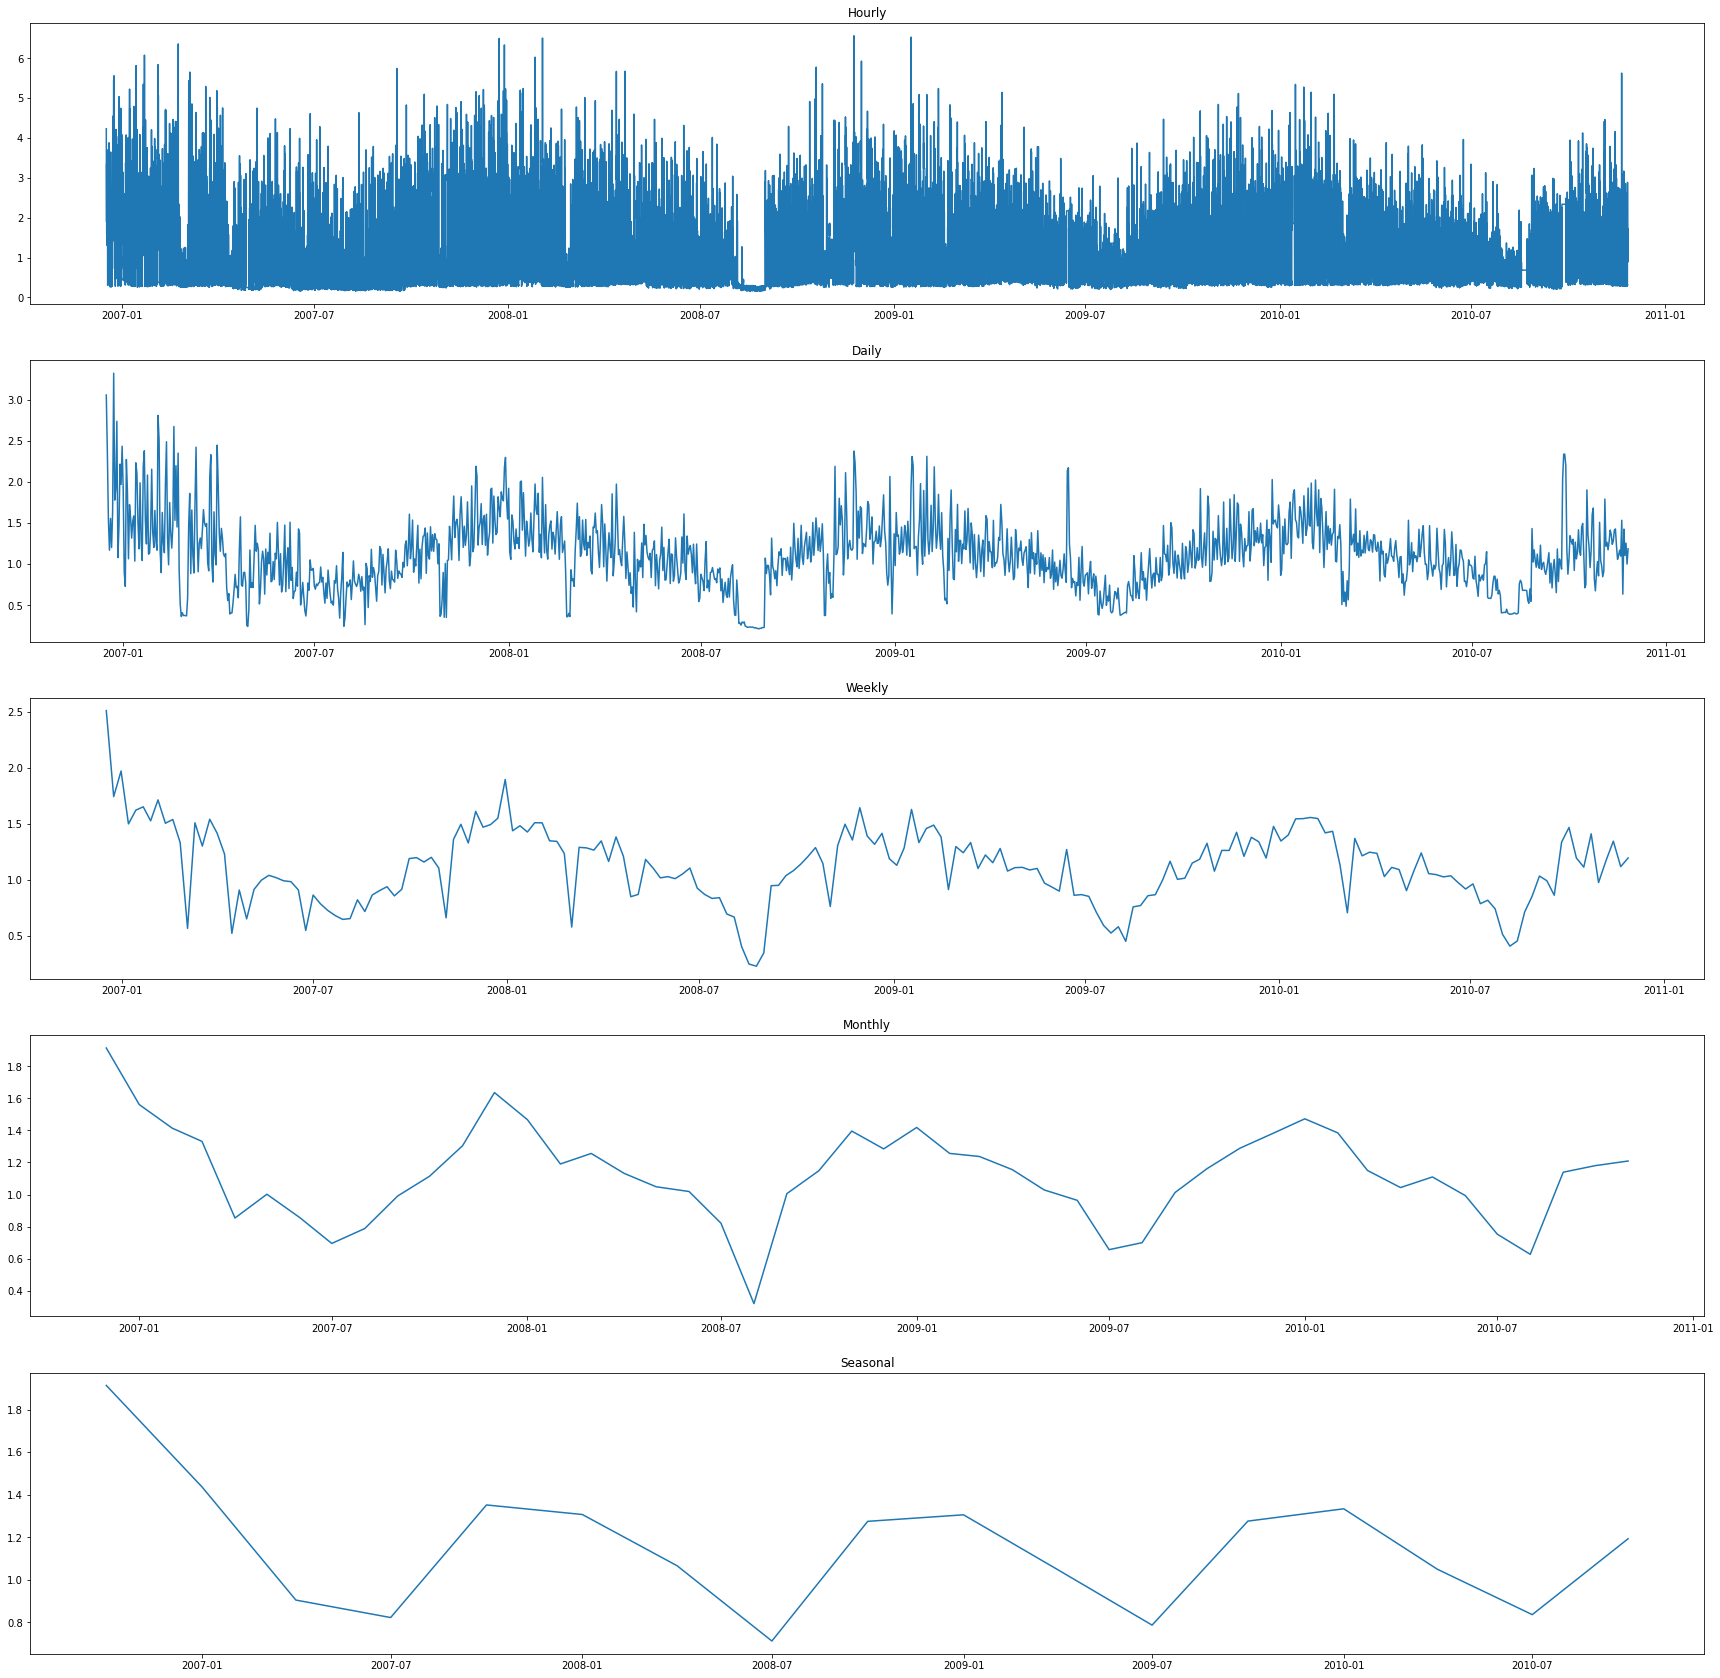

In [11]:
plt.figure(figsize=[30,30])
ax = plt.subplot(5, 1, 1)
plt.plot(hourly_data['Global_apparent_power'])
plt.title('Hourly')
ax = plt.subplot(5, 1, 2)
plt.plot(daily_data['Global_apparent_power'])
plt.title('Daily')
ax = plt.subplot(5, 1, 3)
plt.plot(weekly_data['Global_apparent_power'])
plt.title('Weekly')
ax = plt.subplot(5, 1, 4)
plt.plot(monthly_data['Global_apparent_power'])
plt.title('Monthly')
ax = plt.subplot(5, 1, 5)
plt.plot(seasonal_data['Global_apparent_power'])
plt.title('Seasonal')
plt.show()

##### Select by month

In [ ]:
foo = hourly_data[(hourly_data.index.month == 1) | (hourly_data.index.month == 2)]
# foo = [((hourly_data.index.month == 2) & (2 <= hourly_data.index.day)  # in Feb after the 2nd inclusive
#               | (hourly_data.index.month == 3) & (hourly_data.index.day <= 3))]
# print(foo)
monthly_avg = np.zeros(12)
monthly_std = np.zeros(12)
for i in range(len(monthly_avg)):
    monthly_avg[i] = monthly_data[monthly_data.index.month == i+1]['Global_apparent_power'].mean()
    monthly_std[i] = monthly_data[monthly_data.index.month == i+1]['Global_apparent_power'].std()
print(monthly_avg)
print(monthly_std)

### Data without date

In [ ]:
all_days_data = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?',
                            index_col=0, parse_dates=[0], infer_datetime_format=True, dayfirst=True)
# all_days_data.drop('Date', axis='columns', inplace=True)
# all_days_data['Time'] = (pd.to_datetime(all_days_data['Time'], format='%H:%M:%S') - 
#                          pd.to_datetime(all_days_data['Time'], format='%H:%M:%S').dt.normalize())
# pd.to_datetime(c, format='%H:%M') - pd.to_datetime(c, format='%H:%M').dt.normalize()

In [ ]:
# all_days_data['Time'] = pd.to_datetime(all_days_data['Time'], format='%H:%M:%S')
print(all_days_data['Time'])
# print(type(all_days_data['Time'][0]))
# print(np.sum(all_days_data.index=='17:24:00'))
# idx_cnt = all_days_data.index.value_counts()
# print(idx_cnt)

In [ ]:
all_days_data.dropna(inplace=True)

In [ ]:
# Add apparent power column
all_days_data['Global_apparent_power'] = np.sqrt(all_days_data['Global_active_power']**2 +
                                              all_days_data['Global_reactive_power']**2)

In [ ]:
print(all_days_data)
# print(type(all_days_data.index))

In [ ]:
# plt.figure(figsize=(30,30))
# plt.figure()
# print(all_days_data.iloc[:5, 0])
bar = all_days_data['2007-01-01':'2007-01-08']
# print(bar[bar['Time'] == '00:00:00'])
# print(bar)
# foo = bar['Global_apparent_power'].groupby(bar['Time']).get_group('02:00:00')
foo = bar['Global_apparent_power']
# print(foo)
# print(foo.std())
# print(foo.max() - foo.min())
# plt.scatter(foo.index, foo.values)
foo.hist(bins=200)
# bar.plot.scatter(x='Time', y='Global_apparent_power')
# print(all_days_data['08:00:00' : '08:05:00'].iloc[0])
# all_days_data.plot.scatter(x = df.index, y = 'Global_apparent_power')
# plt.scatter(all_days_data.[''].index, all_days_data.iloc[:2880]['Global_apparent_power'])
# print(plt.xticks())
# print('len =', len(plt.xticks()[0]))
# plt.show()

In [ ]:
time_data = raw_data.copy()
time_data['Time'] = raw_data.index.to_series().dt.time
# print(time_data.loc['2007']['Time'])
time_data.loc['2007']['Global_active_power'].plot()

### SARIMA - From towardsdatascience

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


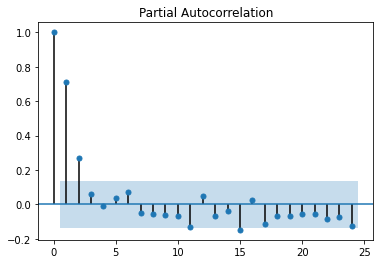

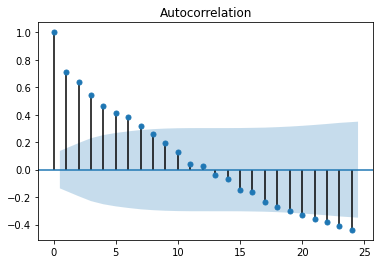

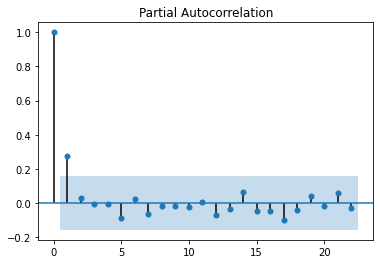

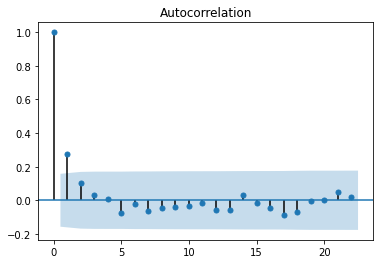

In [9]:
# From https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b

scale = 'week'
if (scale == 'hour'):
    gap = hourly_data['Global_apparent_power']
    season = 8760
elif (scale == 'week'):
    gap = weekly_data['Global_apparent_power']
    season = 52
else:
    gap = filled_data['Global_apparent_power']
    season = 525600
    
plot_pacf(gap);
plot_acf(gap);
# hr_gap.drop(hr_gap.index.values[:2], axis=0).reset_index(drop=True)
# foo = hr_gap.diff(12)
# foo = foo.drop(foo.index.values[:12], axis=0).reset_index(drop=True)
# foo = hr_gap.diff(24)
# foo = foo.drop(foo.index.values[:24], axis=0).reset_index(drop=True)
diff_data = gap.diff(season)
diff_data = diff_data.drop(diff_data.index.values[:season], axis=0)#.reset_index(drop=True)
# foo = hr_gap.diff(12)
# foo = foo.drop(foo.index.values[:12], axis=0).reset_index(drop=True)
plot_pacf(diff_data);
plot_acf(diff_data);
# seasonal_decompose(foo.loc['2008-01':'2008-02'])
# test_stationarity(foo,'hourly data')

In [10]:
ad_fuller_result = adfuller(diff_data)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.94989937459998
p-value: 2.5310120861629452e-17


In [11]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 52
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [12]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    worked = 0
    broken = 0
    for param in tqdm(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            worked += 1
        except:
            broken += 1
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    print('%d worked, %d broke' % (worked, broken))
    print(np.shape(results))
    result_df = pd.DataFrame(results)
    print(result_df)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
result_df = optimize_SARIMA(parameters_list, 0, 0, season, weekly_data['Global_apparent_power'])
result_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


### Bounteous forecasting method

In [12]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


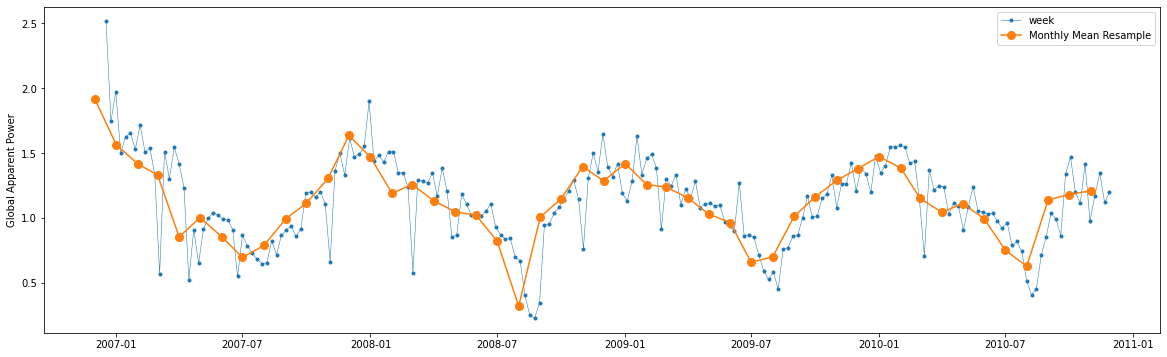

In [46]:
# From https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

scale = 'week'
use_differencing = False
if (scale == 'hour'):
  gap = hourly_data
  season = 8760
elif (scale == 'week'):
  gap = weekly_data['Global_apparent_power']
  season = 52

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(gap, marker='.', linestyle='-', linewidth=0.5, label=scale)
ax.plot(monthly_data['Global_apparent_power'], marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Global Apparent Power')
ax.legend();

In [47]:
# Compute seasonal difference
if (use_differencing):
  gap = gap.diff(season)
  gap = gap.drop(gap.index.values[:season], axis=0)#.reset_index(drop=True)

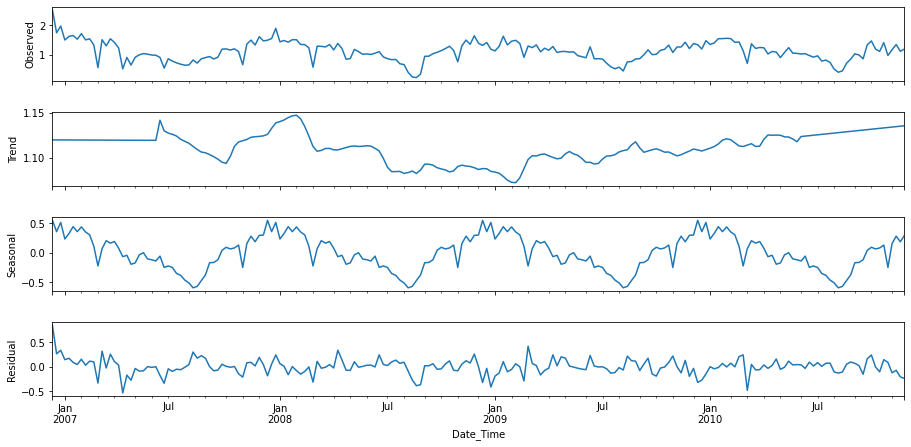

In [48]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    
seasonal_decompose(gap)#.loc['2007-01':'2007-02'])

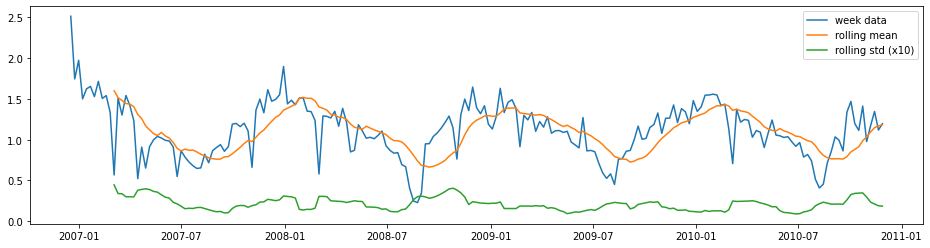

In [49]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(gap,scale+' data')

In [50]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format
              (k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
        
ADF_test(gap, scale+' data')

 > Is the week data stationary ?
Test statistic = -4.173
P-value = 0.001
Critical values :
	1%: -3.462818103072159 - The data is  stationary with 99% confidence
	5%: -2.8758145932936805 - The data is  stationary with 95% confidence
	10%: -2.574378674548251 - The data is  stationary with 90% confidence


#### Separate into Test and Train sets

In [51]:
y_to_train = gap[:'2009'] # dataset to train
y_to_test = gap['2010':] # last year for test  
predict_date = len(gap) - len(gap[:'2019-06-02']) # the number of data points for the test set
# print(len(gap), gap.shape)

#### SARIMA

##### Find Optimal Parameters

In [52]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [53]:
sarima_grid_search(gap, 52)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(1, 0, 0, 52) - AIC:-76.02405912858569


Best parameters for weekly data with no differencing was SARIMA(1, 1, 1)x(1, 0, 0, 52).  
Best parameters for weekly data with differencing was SARIMA(1, 0, 1)x(1, 0, 0, 52)

##### Generate and Evaluate **Model**

In [55]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2185      0.122      1.787      0.074      -0.021       0.458
ma.L1         -0.6610      0.101     -6.577      0.000      -0.858      -0.464
ar.S.L52       0.3232      0.048      6.795      0.000       0.230       0.416
sigma2         0.0337      0.003      9.623      0.000       0.027       0.041


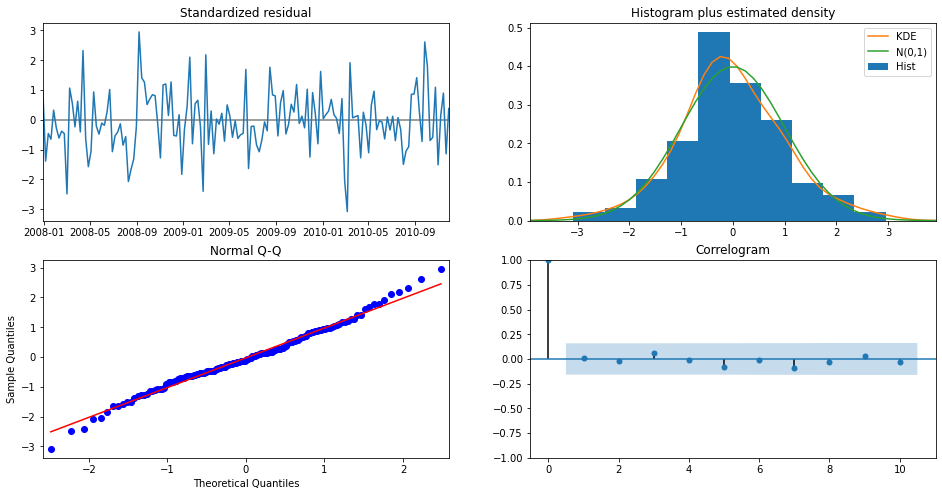

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 0.19


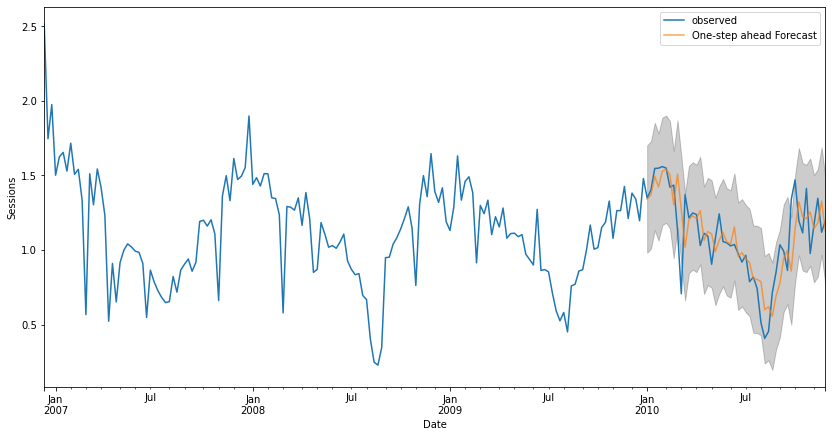

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 0.3


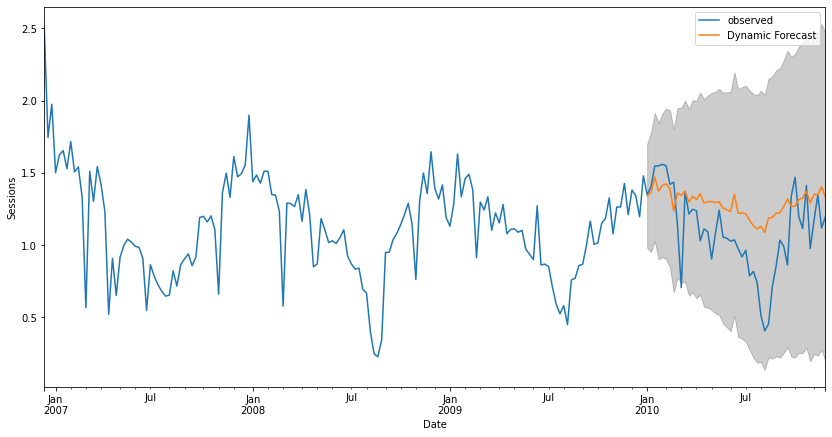

In [56]:
model = sarima_eva(gap,(1, 1, 1),(1, 0, 0, 52),52,y_to_test.index[0],y_to_test)

##### Forecast Future Data

In [57]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

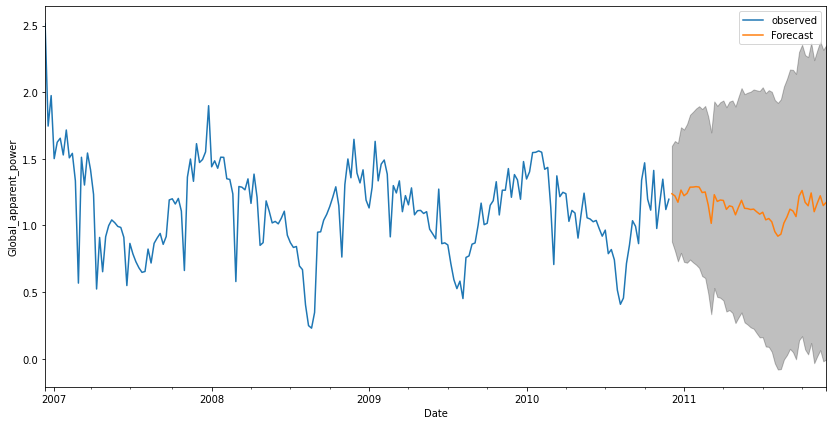

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2010-12-05,1.23723482,0.87754208,1.59692757
1,2010-12-12,1.22130270,0.80949809,1.63310732
2,2010-12-19,1.17361701,0.72971428,1.61751973
3,2010-12-26,1.26494170,0.79371432,1.73616909
4,2011-01-02,1.22263752,0.72611103,1.71916401


In [58]:
final_table = forecast(model,52,gap)
final_table.head()

### Classify power usage as low, average, high, or spike (increasing over last reading by some amount)

In [ ]:
def AddClasses(data, max_low = 0.75, max_avg = 2.0, spike_coeff = 2):
    # Classes:
    # low = 0
    # average = 1
    # high = 2
    # spike = 3
    class_data = data.copy()

    gap = class_data['Global_apparent_power'].values
    cls_arr = np.zeros(class_data.shape[0])

    for i in range(len(gap)):
        pwr = gap[i]
        if (i != 0):
            last_pwr = gap[i-1]
        else:
            last_pwr = 0

        if (i != 0 and pwr >= last_pwr * spike_coeff):
            cls = 3
        elif (pwr < max_low):
            cls = 0
        elif (pwr < max_avg):
            cls = 1
        else:
            cls = 2

        cls_arr[i] = cls

    class_data['Class'] = cls_arr
    return class_data


In [ ]:
class_data = AddClasses(hourly_data)

### Split data into train/test based on year

In [ ]:
train = class_data.loc[:'2009'][['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_remainder']]
train_classes = class_data.loc[:'2009']['Class']
test = class_data.loc['2010':][['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_remainder']]
test_classes = class_data.loc['2010':]['Class']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train, train_classes)
    
    predictions = knn.predict(test)
    score = knn.score(test, test_classes)
    print(score)
    correct = 0
    total = 0
    for k in range(len(predictions)):
        if (test_classes.iloc[k] == 3):
            total += 1
            if (predictions[k] == 3):
                correct += 1

    print('%d / %d correct (%f)' % (correct, total, float(correct) / total))
    print()

In [ ]:
for i in range(10):
    predictions = classifiers[i].predict(test)
    score = classifiers[i].score(test, test_classes)
#     print(predictions)
    print(score)
    correct = 0
    total = 0
    for i in range(len(predictions)):
        if (test_classes.iloc[i] == 3):
            total += 1
            if (predictions[i] == 3):
                correct += 1

    print('%d / %d correct (%f)' % (correct, total, float(correct) / total))